In [103]:
# !pip3 install gradio Pillow scikit-learn

In [104]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
import openai
import math
import gradio as gr
from sklearn.metrics.pairwise import cosine_similarity
import ast
import time
import requests
from PIL import Image
from io import BytesIO

import plotly.graph_objects as go

from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [105]:
df = pd.read_excel("Restaurants + vibes.xlsx")
vibelist = df.columns[7:].tolist()

df_reviews=pd.read_excel("output.xlsx")
df['reviews']= df_reviews['reviews']
df['latitude'] = df['Coordinates'].apply(lambda coord: eval(coord)['latitude'])
df['longitude'] = df['Coordinates'].apply(lambda coord: eval(coord)['longitude'])

In [106]:
placa_catalunya_gps=(41.38727843624228, 2.17009163004613)

In [107]:
def get_GPT(prompt, model="gpt-3.5-turbo", retries=5, backoff_factor=2, temp=0.7):
    for attempt in range(retries + 1):
        try:
            completion = openai.ChatCompletion.create(
                model=model,
                stop="\n",
                temperature=temp,
                messages=prompt              
            )
            return completion.choices[0].message.content
        except openai.error.RateLimitError as e:
            print("RateLimit :(")
            if attempt < retries:
                sleep_time = (backoff_factor ** attempt) 
                time.sleep(sleep_time)
            else:
                raise
        except openai.error.APIError as e:
            print(f"APIError: {e}")
            if attempt < retries:
                sleep_time = (backoff_factor ** attempt)
                time.sleep(sleep_time)
            else:
                raise
        except RequestException as e:
            print(f"RequestException: {e}")
            if attempt < retries:
                sleep_time = (backoff_factor ** attempt)
                time.sleep(sleep_time)
            else:
                raise

In [108]:
def get_datapoint_prompt(row):
    datapoint_string = ""
    for n, r in enumerate([x['text'] for x in ast.literal_eval(row['reviews'])]):
        r = r.replace("\n", " ")
        datapoint_string +=(f"{n+1}) {r}\n")
    datapoint_string = f"DATA:\n{row['Name']}\n\nTop 3 review previews:\n{datapoint_string}\nList of vibes:\n[Quirkadelic, Rainbow, Artsy, Hipster, Cozy, Industrial, Exotic, Sleek, Nostalgic, Glamorous, Sophisticated, Funky, Ethnic, Underground, Spirited, Folksy, Edgy, Innovative, Sustainable, Cosmopolitan, Garden-inspired, Invigorating, Chic]\n\nVector of values for each vibe:"    
    messages = [
                    {"role": "system", "content": """Ignore all previous instructions.Your task is now to help label data. You must respond
with a list of -1, 0, and 1, for example [0, 1, 0, -1 ...1] that is the length of the list of vibes.\nYou will receive a restaurant name, and three reviews from Google Maps. Based on your analysis of the reviews, you must consider each vibe in the list of vibes and assign it a score, 1 if this vibe is applicable to the restaurant, 0 if it is not relevant or there is not enough information to decide, and -1 if this vibe is especially untrue of this restaurant."""},
                    {"role": "user", "content": f"{datapoint_string}"}
                ]
    return messages

def get_user_prompt(user_description):
    datapoint_string = f""    
    messages = [
                    {"role": "system", "content": """Ignore all previous instructions. Your task is now to help label data. You must respond with a list of -1, 0, and 1, for example [0, 1, 0, -1 ...1] that is the length of the list of vibes.\nYou will receive a short text from a user describing the kind of restaurant they want to find. Analyze the text, and consider the type of place this user is looking to find. Based on this analysis, consider each vibe in the list of vibes, and assign it a score, 1 if this vibe is applicable to the kind of place the user is looking for, 0 if it is not relevant or there is not enough information to decide, and -1 if the user would like to avoid this vibe."""},
                    {"role": "user", "content": f"USER TEXT:\n{user_description}\nList of vibes:\n[Quirkadelic, Rainbow, Artsy, Hipster, Cozy, Industrial, Exotic, Sleek, Nostalgic, Glamorous, Sophisticated, Funky, Ethnic, Underground, Spirited, Folksy, Edgy, Innovative, Sustainable, Cosmopolitan, Garden-inspired, Invigorating, Chic]\n\nVector of values for each vibe:"}
                ]
    return messages

In [109]:
def retrieve_similar_items(dataset, user_input):
    # Compute cosine similarity between dataset and user input
    similarity_scores = cosine_similarity(df[vibelist], [user_vector])

    # Convert similarity scores to a 1D array
    similarity_scores = similarity_scores.flatten()

    # Get indices and scores of top 10 most similar items
    if len(dataset) >= 10:
        top_indices = np.argsort(similarity_scores)[-10:][::-1]
        top_scores= np.sort(similarity_scores)[-10:][::-1]
    else:
        top_indices = np.argsort(similarity_scores)[::-1]
        top_scores= np.sort(similarity_scores)[::-1]
    return top_indices, top_scores

In [110]:
def fetch_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

In [122]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Radius of the Earth in meters
    radius = 6371000  # meters
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    
    return distance

def calculate_distances(df, user_location):
    user_lat, user_lon = user_location
    
    # Apply the haversine_distance function to calculate distance for each row
    distance_list = df.apply(lambda row: haversine_distance(row['latitude'], row['longitude'], user_lat, user_lon), axis=1)
    
    return distance_list

def filter_dataframe_by_distance(df, userLocation=placa_catalunya_gps, maxDistance=500):
    maxDistance=maxDistance * 1000 #convert to km lol
    filtered_df=df.loc[calculate_distances(df, userLocation)<maxDistance]
    return filtered_df

In [112]:
def wy_map(df):
    names = df["Name"].tolist()
    prices = df["Price"].tolist()
    ratings = df["Rating"].tolist()
    text_list = [(names[i], prices[i], ratings[i]) for i in range(0, len(names))]
    fig = go.Figure(go.Scattermapbox(
            customdata=text_list,
            lat=df['latitude'].tolist(),
            lon=df['longitude'].tolist(),
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=6
            ),
            hoverinfo="text",
            hovertemplate='%{customdata[0]} Price: %{customdata[1]} Rating: %{customdata[2]}'
        ))

    fig.update_layout(
        mapbox_style="open-street-map",
        hovermode='closest',
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=placa_catalunya_gps[0],
                lon=placa_catalunya_gps[1]
            ),
            pitch=0,
            zoom=12
        ),
    )

    return fig

In [125]:
def input_output(user_text, distance_slider=0):
    '''
    first, filter dataframe based on conditions, i.e. handle user input filters
    second, get vector representation of users input
    third, retrieve similar restaurants from the dataframe df
    fourth, output list of restaurants and map with markers using name+rating+cost as hovertext 
    '''
    #Step 1
    user_lat, user_lon = placa_catalunya_gps
    if distance_slider > 0:
        filtered_df = filter_dataframe_by_distance(df, placa_catalunya_gps, distance_slider)
    else:
        filtered_df = df
    #Step 2
    user_prompt = get_user_prompt(user_text)
    for attempt in range(5):
        temp = 0.5 - (attempt/10)
        response = get_GPT(user_prompt, model="gpt-4", temp=temp)
        try:
            v = ast.literal_eval(response)
            if len(v) == len(vibelist):
                user_vector = v
                break
        except:
            print(response)
    #Step 3
    top_indices, top_scores = retrieve_similar_items(filtered_df, user_vector)
    filtered_df = filtered_df.iloc[top_indices]
    #Step 4 get map
    fig = wy_map(filtered_df)
    #formating the final answer 
    restaurant_list_string = "this is a list of restaurants that you should check out!"
    for idx in top_indices:
        restaurant_list_string += "\n" + str(filtered_df.loc[idx].Name)
    # try to get image of restaurant
    img_url=filtered_df["Image_url"].iloc[0]
    pil_image = fetch_image(img_url)
    return restaurant_list_string, pil_image, fig
        

In [123]:
filtered_df.loc[24]

Name                                                       Stoke Bar
Image_url          https://s3-media2.fl.yelpcdn.com/bphoto/Khi43e...
Categories         [{'alias': 'pubs', 'title': 'Pubs'}, {'alias':...
Rating                                                           4.0
Price                                                             €€
Coordinates          {'latitude': 41.382201, 'longitude': 2.1751135}
Location                                   Carrer dels Banys Nous, 8
Quirkadelic                                                        0
Rainbow                                                            0
Artsy                                                              0
Hipster                                                            1
Cozy                                                               1
Industrial                                                         0
Exotic                                                             0
Sleek                             

In [140]:
filter_dataframe_by_distance(df, userLocation=placa_catalunya_gps, maxDistance=0.5)

,Name,Image_url,Categories,Rating,Price,Coordinates,Location,Quirkadelic,Rainbow,Artsy,...,Edgy,Innovative,Sustainable,Cosmopolitan,Garden-inspired,Invigorating,Chic,reviews,latitude,longitude
4,Onofre,https://s3-media1.fl.yelpcdn.com/bphoto/_G7llE...,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,€€,"{'latitude': 41.38627, 'longitude': 2.17455}","Carrer de les Magdalenes, 19",0,0,0,...,0,0,0,0,0,0,0,"[{'id': 'r74M4tmuW078d48myZPhvg', 'url': 'http...",41.386270,2.174550
5,El Pinar,https://s3-media1.fl.yelpcdn.com/bphoto/l650_E...,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,€,"{'latitude': 41.3841557, 'longitude': 2.1733618}","Carrer del Duc, 7",0,0,0,...,0,0,0,0,0,0,0,"[{'id': '5SPfHRuOY2oyx0dd3NgM6g', 'url': 'http...",41.384156,2.173362
7,El Macareno,https://s3-media1.fl.yelpcdn.com/bphoto/6SX6H6...,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",4.5,€€,"{'latitude': 41.3845, 'longitude': 2.16962}","Carrer de les Sitges, 10",-1,-1,0,...,0,0,0,0,0,0,0,"[{'id': 'YkeSlH72WCKju9p2PExwoA', 'url': 'http...",41.384500,2.169620
13,Prado de Flores,https://s3-media1.fl.yelpcdn.com/bphoto/yZB_RN...,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",4.0,€€,"{'latitude': 41.3850770858273, 'longitude': 2....","Carrer de Santa Anna, 11",0,0,0,...,0,0,0,1,0,0,0,"[{'id': 'z3vP6WH14CB9zG7gwO0oNQ', 'url': 'http...",41.385077,2.171252
15,Living Barcelona 1925,https://s3-media2.fl.yelpcdn.com/bphoto/9X6kkd...,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.0,€€,"{'latitude': 41.383831, 'longitude': 2.1714399}","Ramblas, 122",0,0,0,...,0,0,0,1,0,0,0,"[{'id': 'vN4-v_Bu96LqmCRw0DijJw', 'url': 'http...",41.383831,2.171440
19,El Jardín del Edén,https://s3-media4.fl.yelpcdn.com/bphoto/AGGuMB...,"[{'alias': 'tapas', 'title': 'Tapas Bars'}, {'...",4.0,€€,"{'latitude': 41.38521, 'longitude': 2.16784}","Carrer de Jovellanos, 3",-1,-1,0,...,0,0,0,0,0,0,0,"[{'id': 'bd5zH3K2vbGzufCFpwxuvA', 'url': 'http...",41.385210,2.167840
26,Bar Lobo,https://s3-media3.fl.yelpcdn.com/bphoto/QWkAok...,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",3.5,€€,"{'latitude': 41.3832467534745, 'longitude': 2....","Carrer de Pintor Fortuny, 3",0,0,0,...,0,0,0,0,0,0,0,"[{'id': '0I46LvPm9mgrJfK5u5J1og', 'url': 'http...",41.383247,2.170545
33,Cèntric,https://s3-media1.fl.yelpcdn.com/bphoto/rPyp_E...,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",4.0,€€,"{'latitude': 41.384699, 'longitude': 2.1681859}","Carrer de les Ramelleres, 27",0,0,0,...,0,0,0,1,0,0,0,"[{'id': 'H6r0M1c4FBwzJ1LMOJQVCg', 'url': 'http...",41.384699,2.168186
34,La Masia,https://s3-media2.fl.yelpcdn.com/bphoto/eR_dEv...,"[{'alias': 'tapas', 'title': 'Tapas Bars'}, {'...",4.0,€,"{'latitude': 41.38322, 'longitude': 2.16833}","Carrer d'Elisabets, 16",0,0,0,...,0,0,0,0,0,0,0,"[{'id': '0WknFEw9NagTb5x2j1IBmw', 'url': 'http...",41.383220,2.168330
37,Chivuo's,https://s3-media1.fl.yelpcdn.com/bphoto/LgI6Ql...,"[{'alias': 'burgers', 'title': 'Burgers'}, {'a...",4.0,€€,"{'latitude': 41.3830033214929, 'longitude': 2....","Carrer del Pintor Fortuny, 15",0,0,0,...,0,0,0,1,0,0,0,"[{'id': 'kite7XhuJm5WiZHNqLMghg', 'url': 'http...",41.383003,2.169956


In [131]:
l, p, f = input_output("I want an amazing experience with glittering champagne glasses", 300)

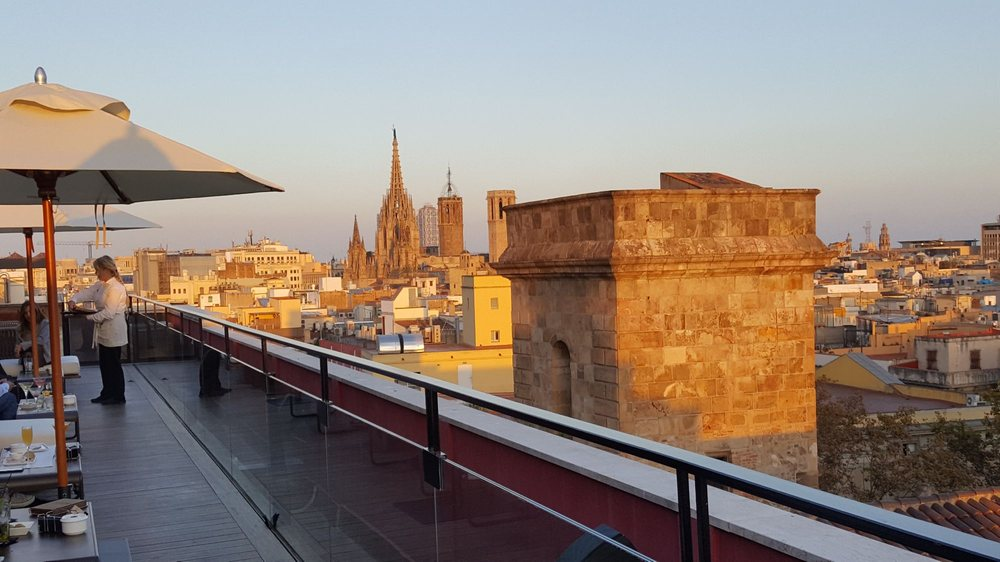

In [132]:
p

"this is a list of restaurants that you should check out!\nTerrace la Isabela\nViana\nPatagonia\nPrado de Flores\nL'Antiquari\nMénage à Trois\nAbsenta 1893\nOcaña\nEnkel\nAzul Frida"

In [79]:
gr.Interface(fn=input_output, 
            inputs=[gr.inputs.Textbox(lines=3, default="please tell we what kind of restaurant you want to visit", label="search prompt"), "slider"], 
            outputs=[gr.outputs.Textbox(label="search result"),
                     "image",
                     gr.Plot(label="map")],
            layout="horizontal"
             ).launch(debug=True, share=True)

/home/fbane/.local/lib/python3.8/site-packages/gradio/inputs.py:27: UserWarning:

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components

/home/fbane/.local/lib/python3.8/site-packages/gradio/inputs.py:30: UserWarning:

`optional` parameter is deprecated, and it has no effect

/home/fbane/.local/lib/python3.8/site-packages/gradio/inputs.py:30: UserWarning:

`numeric` parameter is deprecated, and it has no effect

/home/fbane/.local/lib/python3.8/site-packages/gradio/outputs.py:22: UserWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components

<ipython-input-79-eb3ddd114177>:1: UserWarning:

`layout` parameter is deprecated, and it has no effect



Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://99a345d1e9f7450f28.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://99a345d1e9f7450f28.gradio.live
